In [1]:
%matplotlib widget

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

In [2]:
# TODO ref https://matplotlib.org/stable/users/explain/animations/blitting.html
class BlitManager:
    def __init__(self, canvas, animated_artists=()):
        """
        Parameters
        ----------
        canvas : FigureCanvasAgg
            The canvas to work with, this only works for subclasses of the Agg
            canvas which have the `~FigureCanvasAgg.copy_from_bbox` and
            `~FigureCanvasAgg.restore_region` methods.

        animated_artists : Iterable[Artist]
            List of the artists to manage
        """
        self.canvas = canvas
        self._bg = None
        self._artists = []

        for a in animated_artists:
            self.add_artist(a)
        # grab the background on every draw
        self.cid = canvas.mpl_connect("draw_event", self.on_draw)

    def on_draw(self, event):
        """Callback to register with 'draw_event'."""
        cv = self.canvas
        if event is not None:
            if event.canvas != cv:
                raise RuntimeError
        self._bg = cv.copy_from_bbox(cv.figure.bbox)
        self._draw_animated()

    def add_artist(self, art):
        """
        Add an artist to be managed.

        Parameters
        ----------
        art : Artist

            The artist to be added.  Will be set to 'animated' (just
            to be safe).  *art* must be in the figure associated with
            the canvas this class is managing.

        """
        if art.figure != self.canvas.figure:
            raise RuntimeError
        art.set_animated(True)
        self._artists.append(art)

    def _draw_animated(self):
        """Draw all of the animated artists."""
        fig = self.canvas.figure
        for a in self._artists:
            fig.draw_artist(a)

    def update(self):
        """Update the screen with animated artists."""
        cv = self.canvas
        fig = cv.figure
        # paranoia in case we missed the draw event,
        if self._bg is None:
            self.on_draw(None)
        else:
            # restore the background
            cv.restore_region(self._bg)
            # draw all of the animated artists
            self._draw_animated()
            # update the GUI state
            cv.blit(fig.bbox)
        # let the GUI event loop process anything it has to do
        cv.flush_events()

In [3]:
import collections

class OrderedSetDict(collections.OrderedDict):
    def add(self, v):
        self[v] = v

    def remove(self, v):
        return self.pop(v)

# TODO NOTE data format {<callable>: <callable>} {<key>: <callable>}
class CallableSet(OrderedSetDict):
    def __call__(self, *args, **kwargs):
        return {
            key: f.__call__(*args, **kwargs)
                for key, f in self.items()
        }

In [4]:
import abc

import matplotlib
import matplotlib.artist

import typing

import functools


class BaseArtist(matplotlib.artist.Artist, abc.ABC):
    @functools.cached_property
    def _step_callbacks(self):
        class _Callbacks(OrderedSetDict):
            @classmethod
            def _entry_encode(cls, func, *args, **kwargs):
                return tuple(
                    (func, args, tuple(kwargs.items()))
                )

            def __init__(self, *args, func_resolver=None, **kwargs):
                self._func_resolver = func_resolver

            def add(self, func, *args, **kwargs):
                return super().add(
                    self.__class__._entry_encode(func, *args, **kwargs)
                )

            def remove(self, func, *args, **kwargs):
                return super().remove(
                    self.__class__._entry_encode(func, *args, **kwargs)
                )

            def __call__(self):
                def _func_handler(f):
                    nonlocal self
                    if callable(f): return f
                    if self._func_resolver is not None: 
                        return self._func_resolver(f)
                    raise TypeError

                return {
                    key: _func_handler(f).__call__(
                        *(f_args() for f_args in args_factory), 
                        **{name: f_kwargs() for name, f_kwargs in kwargs_factory}
                    ) for key, (f, args_factory, kwargs_factory) in self.items()
                }

        return _Callbacks(
            # NOTE instance method needs to be unbounded hence the `.__func__`
            func_resolver=lambda name: getattr(self, name).__func__
        )

    # TODO NOTE format: <instance_method_name>, <args_factory>
    # TODO NOTE example: .on_step('set_data', lambda: [1, 2, 3])
    # TODO NOTE example: .on_step(lambda self, a: self.set_data(a), lambda: [1, 2, 3])
    def on_step(
        self, 
        callback: typing.Callable | str,
        *args_factory, **kwargs_factory
    ):
        self._step_callbacks.add(
            callback,
            lambda: self,
            *args_factory, **kwargs_factory
        )
        return self

    def step(self):
        self._step_callbacks()

    # TODO remove !!!!
    '''
    def set_factory(self, **prop_factories):
        self._prop_factories = prop_factories
        return self
    
    def step(self, *args, **kwargs):
        if not hasattr(self, '_prop_factories'):
            return
        return self.set(**{
            prop_name: f(*args, **kwargs)
                for prop_name, f in self._prop_factories.items()
        })
    '''

class BaseFlexArtist(BaseArtist):
    def autofit(self, enable=True):
        self._autofit = enable
        return self

    def step(self, *args, **kwargs):
        res = super().step(*args, **kwargs)
        if getattr(self, '_autofit', False):
            self.axes.relim()
            self.axes.autoscale_view()
        return res


import typing
import matplotlib.figure


class FigureAnimation:
    def __init__(
        self, 
        fig: matplotlib.figure.Figure, 
        animated_artists: typing.Collection[matplotlib.artist.Artist] = ()
    ):
        self._blit_manager = BlitManager(
            canvas=fig.canvas, 
            animated_artists=animated_artists
        )

    def add_artists(self, *arts):
        for art in arts:
            self._blit_manager.add_artist(art)
        return self

    def step(self, *args, **kwargs):
        for art in self._blit_manager._artists:
            if not isinstance(art, BaseArtist):
                continue
            art.step(*args, **kwargs)
        self._blit_manager.update()

import matplotlib.lines

class Line2D(matplotlib.lines.Line2D, BaseFlexArtist):
    def __init__(self, xdata=[], ydata=[], **kwargs):
        return super().__init__(xdata, ydata, **kwargs)

    def extend_data(self, *datas, orig=True):
        self.set_data(*(
            [*old_data, *data]
            for old_data, data in 
            zip(self.get_data(orig=orig), datas)
        ))

    def append_data(self, *datas, orig=True):
        return self.extend_data(*([d] for d in datas), orig=orig)

class SimpleLine2D(Line2D):
    @classmethod
    def _f_xdata(cls, ydata, start=0, step=1):
        return range(start, start + len(ydata), step)

    def set_data_1d(self, ydata):
        self.set_data(
            self.__class__._f_xdata(ydata),
            ydata
        )

    def extend_data_1d(self, ydata, orig=True):
        return self.set_data_1d(
            [*self.get_ydata(orig=orig), *ydata]
        )

    def append_data_1d(self, ydata, orig=True):
        return self.extend_data_1d([ydata], orig=orig)


In [6]:
import importlib

utils = importlib.import_module('utils', '.')
_ = importlib.import_module('utils.graphing', '.')

In [8]:
FigureAnimation = utils.graphing.FigureAnimation
SimpleLine2D = utils.graphing.SimpleLine2D

utils.graphing.FigureAnimation

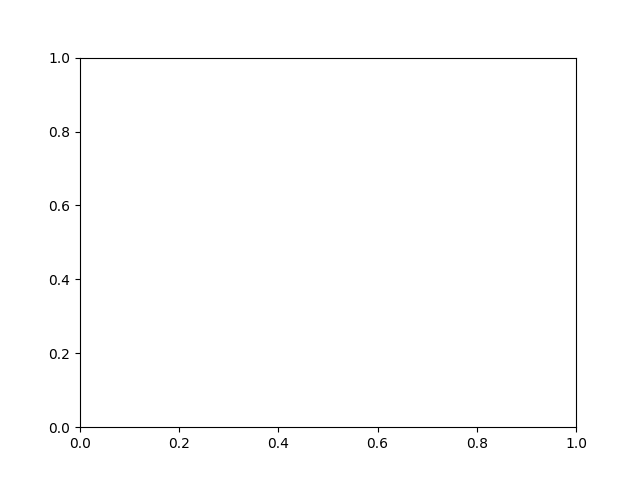

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.ion()
fig, ax = plt.subplots()
# TODO
#ax.set(autoscale_on=True)

import numpy as np

animation = FigureAnimation(
    fig, 
    [
        ax.add_artist(
            SimpleLine2D()
            .autofit()
            .on_step('append_data_1d', np.random.random)
        )
    ]
)

#fig.show()

In [7]:
for _ in range(10):
    animation.step()
    #ax.relim()
    #ax.autoscale_view()

In [8]:
import ooep
import ooep.utils
import ooep.ems

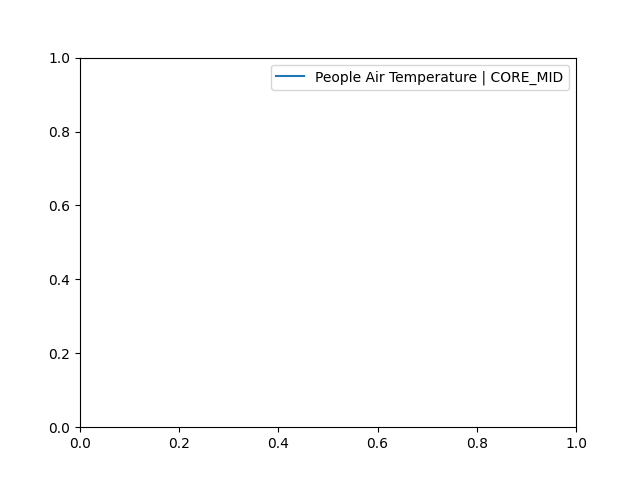

In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt

env = ooep.ems.Environment().__enter__()

tmeter = env.variable(dict(
    variable_name='People Air Temperature',
    variable_key='CORE_MID'
))

plt.ion()
fig, ax = plt.subplots()
animation = FigureAnimation(
    fig, 
    [
        ax.add_artist(
            SimpleLine2D(label=tmeter.name)
            .autofit()
            .on_step('append_data_1d', lambda: tmeter.value)
        )
    ]
)
ax.legend()

def _f_callback():
    if env.warming_up:
        return
    try: animation.step()
    except ooep.ems.NotReadyError: pass

env.event(
    dict(event_name='begin_zone_timestep_after_init_heat_balance')
    #dict(event_name='after_component_input')
).callback = _f_callback

In [13]:
# TODO async
env(
    # TODO
    '--design-day',
    #'--annual',
    '--output-directory', 'build/demo-eplus',
    '--weather', f'{ooep.utils.energyplus.dataset.weathers}/USA_FL_Tampa.Intl.AP.722110_TMY3.epw',
    f'{ooep.utils.energyplus.dataset.models}/ASHRAE901_OfficeLarge_STD2019_Denver_Chiller205_Detailed.idf'
)

0

In [11]:
env.__exit__()
